# Toy Radix Lagrangean decomposition validation

In [1]:
OBJECTIVE    = 'minsse'
#OBJECTIVE    = 'minerr'
REG_WEIGHT   = 0. #1e-4
MAX_NONZERO  = None #48*2
PREVENT_ZERO = True
POWERS       = [-1,0,1]
TWO_PHASE    = False

In [2]:
%load_ext line_profiler

In [3]:
from gurobipy import *

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['svg.fonttype'] = 'none'
pd.set_option('display.max_colwidth', -1)
%matplotlib inline

from cobra.io import load_json_model
from six import iteritems
import numpy as np
import cobra

In [4]:
ijomc = load_json_model('/home/laurence/ME/models/e_coli_core_pc.json')

In [5]:
ijomc.optimize()
mu_crowd0 = ijomc.reactions.BIOMASS_Ecoli_core_w_GAM.x
print(mu_crowd0)

0.873921506968


In [6]:
df_meas = pd.read_csv('/home/laurence/ME/data/dynamicME/beg/growth_meas.csv')

ex_rxns = [r for r in df_meas.ex_rxn.unique() if ijomc.reactions.has_id(r)]
df_meas = df_meas[ df_meas.ex_rxn.isin(ex_rxns)]
conds = df_meas.substrate.unique()

N_CONDS = len(conds)
#N_CONDS = ['succinate','malate']

df_conds = pd.DataFrame([{'cond':r['substrate'], 'rxn':ex_rxn, 'lb':-10 if r['ex_rxn']==ex_rxn else 0, 'ub':1000., 'obj':0.} for i,r in df_meas.iterrows() for ex_rxn in ex_rxns])

if hasattr(N_CONDS,'__iter__'):
    df_conds = df_conds[ df_conds.cond.isin(N_CONDS)]
    N_CONDS = len(N_CONDS)
else:
    if N_CONDS==1:
        df_conds = df_conds[ df_conds.cond=='acetate']
    elif N_CONDS<=3:
        df_conds = df_conds[ df_conds.cond.isin(['glucose','acetate','succinate'][0:N_CONDS])]
    else:
        df_conds = df_conds[ df_conds.cond.isin(conds[0:N_CONDS])]

df_conds.loc[ (df_conds.cond=='acetate') & (df_conds.rxn=='EX_ac_e'), 'lb'] = -20

# Make radix problem

In [7]:
from dynamicme.estimate import RadixEstimator

In [8]:
df_Y = df_meas.rename(columns={'growth_rate_1_h':'output', 'substrate':'cond'})
df_Y.loc[:,'output_id'] = 'BIOMASS_Ecoli_core_w_GAM'
df_X = df_conds

In [9]:
est = RadixEstimator()
est.fit(ijomc, df_X, df_Y, objective=OBJECTIVE,
        reg_weight = REG_WEIGHT, max_nonzero_binaries=MAX_NONZERO, optimize=False,
       powers=POWERS)

est.milp.Params.ScaleFlag = 0
est.milp.Params.OutputFlag = 1
est.milp.Params.TimeLimit = 2*3600.
# est.milp.Params.Presolve = 0
# est.milp.Params.FeasibilityTol = 1e-8
# est.milp.Params.OptimalityTol = 1e-8

# est.optimize()

Changed value of parameter OutputFlag to 1
   Prev: 0  Min: 0  Max: 1  Default: 1
Changed value of parameter ScaleFlag to 0
   Prev: -1  Min: -1  Max: 3  Default: -1
Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Changed value of parameter TimeLimit to 7200.0
   Prev: 1e+100  Min: 0.0  Max: 1e+100  Default: 1e+100


## Validate the fit

base_model = load_json_model('/home/laurence/ME/models/e_coli_core_pc.json')

mu_id = 'BIOMASS_Ecoli_core_w_GAM'
df_pred = est.predict(df_X, base_model, meas_id=mu_id)

df_Y2 = df_Y[[c for c in df_Y.columns if c not in ['order','ex_rxn']]]
df_val = pd.merge(df_Y2.rename(columns={'output':'meas'}), df_pred.rename(columns={'rxn':'output_id','x':'pred'}), on=['cond','output_id'])
df_val.loc[:,'error'] = (df_val.pred - df_val.meas)
df_val.loc[:,'perror'] = df_val.error / df_val.meas * 100
df_val

a0 = 1./65/3600
kfit_dict0 = {k:a0 for k in est.kfit_dict.keys()}
df_ref = est.predict(df_X, base_model, meas_id=mu_id, kfit_dict=kfit_dict0)
df_ref.rename(columns={'rxn':'output_id','x':'output'}, inplace=True)

df_val0 = pd.merge(df_Y2.rename(columns={'output':'meas'}), df_ref.rename(columns={'output':'pred0'}), on=['cond','output_id'])
df_val0.loc[:,'error0'] = (df_val0.pred0 - df_val0.meas)
df_val0.loc[:,'perror0'] = df_val0.error0 / df_val0.meas * 100

df_comp = pd.merge(df_val, df_val0, on=['cond','output_id','meas'])
df_comp.loc[:,'error_change'] = (df_comp.error.abs()-df_comp.error0.abs()) / df_comp.error0.abs() * 100
df_comp

print('Total abs error: %g' % df_comp.error.abs().sum())
print('Total perc error: %g%%' % df_comp.perror.abs().sum())
print('Total error change: %g%%' % df_comp.error_change.sum())
changed = [abs(est.kfit_dict[k]-kfit_dict0[k])>1e-9 for k in est.kfit_dict.keys()]
print('Number of keffs changed: %d/%d (%g%%)' % (sum(changed),len(est.kfit_dict), 100*sum(changed)/len(est.kfit_dict) ))

# Each Lagrange submodel should start with the optimum

In [10]:
from dynamicme.decomposition import LagrangeMaster, LagrangeSubmodel

In [11]:
conds = df_conds.cond.unique()
sub_dict = {}
for cond in conds:
    df_Xk = df_X[ df_X.cond==cond]
    df_Yk = df_Y[ df_Y.cond==cond]
    estk = RadixEstimator()
    estk.fit(ijomc, df_Xk, df_Yk, objective=OBJECTIVE,
             reg_weight = REG_WEIGHT, max_nonzero_binaries=MAX_NONZERO, optimize=False,
            powers=POWERS)
    sub = LagrangeSubmodel(estk.stacker.model, cond, Q=estk.stacker.Q)
    sub_dict[cond] = sub

Changed value of parameter OutputFlag to 1
   Prev: 0  Min: 0  Max: 1  Default: 1
Changed value of parameter OutputFlag to 1
   Prev: 0  Min: 0  Max: 1  Default: 1
Changed value of parameter OutputFlag to 1
   Prev: 0  Min: 0  Max: 1  Default: 1
Changed value of parameter OutputFlag to 1
   Prev: 0  Min: 0  Max: 1  Default: 1
Changed value of parameter OutputFlag to 1
   Prev: 0  Min: 0  Max: 1  Default: 1


In [12]:
master = LagrangeMaster(estk.stacker.model)
master.add_submodels(sub_dict)

In [13]:
for sub in sub_dict.values():
    sub.model.Params.MIPGapAbs = 1e-3
    sub.model.Params.MIPGap    = 1e-3

In [14]:
is_bin = [y.upper_bound<=1 for y in master._y0]
np.all(is_bin)

True

### Two-phase

In [15]:
master.time_limit = 2*3600
#master.max_iter = 500
master.verbosity = 2
master.print_iter = 5
# master.gaptol = 0.02
master.gaptol = 1e-3
master.absgaptol = 1e-3
master.delta_min  = 1e-20
master.delta_mult = 0.5
#master.bundle_mult = 0.1
feasible_methods = ['heuristic', 'enumerate']
alt_method = 'pool'
max_alt = 10    # Computationally expensive if too large. Might miss feasible solution if too small.
                # Can make adaptive if no feasible solution found for certain iterations.
                # Adaptively update num of alt opt to keep.

if TWO_PHASE:
    sol_master = master.solve_relaxed(feasible_methods=None)
    df_phase1 = pd.DataFrame(master.log_rows)
    
sol_master = master.optimize(feasible_methods=feasible_methods, max_alt=max_alt, alt_method=alt_method,
                             early_heuristics=['average'], nogood_cuts = True) 
df_phase2 = pd.DataFrame(master.log_rows)

    Iter                    UB                    LB       gap relgap(%)   penalty                       Time(s)
  ------   -------------------   -------------------  -------- ---------  -------- -----------------------------
               Best   Feasible        Sub       Best                                   total    master       sub
Best Heuristic solution has objval=0.0490761799601
       0    0.04908    0.04908   0.004107   0.004107   0.04497     91.63         0  0.493134  0.000786  0.381172
Best Heuristic solution has objval=0.0490761799596
       5    0.04908    0.04908     -5.641   0.004107   0.04497     91.63    0.0281  1.387773  0.001602  0.155750
Best Heuristic solution has objval=0.047405745408
Best Heuristic solution has objval=0.0433847931041
      10    0.03421    0.04338      -8.16   0.004107    0.0301     87.99   0.00142  2.339932  0.003352  0.143660
      15    0.03147    0.04338     -11.68   0.004107   0.02736     86.95  0.000107  3.490966  0.005916  0.268023
      

In [16]:
df_phase2 = pd.DataFrame(master.log_rows)

In [17]:
df_phase2

,LB,bestLB,bestUB,delta,feasUB,gap,iter,relgap,res_u,t_master,t_sub,t_total
0,0.004107,0.004107,0.049076,1.000000e+00,0.049076,0.044969,0,91.631088,0.000000e+00,0.000786,0.381173,0.412947
1,-50.190924,0.004107,0.049076,5.000000e-01,0.049076,0.044969,1,91.631088,1.220000e+01,0.000746,0.129031,0.652615
2,-25.183845,0.004107,0.049076,2.500000e-01,0.049076,0.044969,2,91.631088,1.938045e+00,0.000916,0.132903,0.816549
3,-26.048404,0.004107,0.049076,1.250000e-01,0.049076,0.044969,3,91.631088,7.976778e-01,0.001084,0.128266,0.974769
4,-6.923638,0.004107,0.049076,6.250000e-02,0.049076,0.044969,4,91.631088,6.408224e-02,0.001484,0.194843,1.200610
5,-5.641248,0.004107,0.049076,3.125000e-02,0.049076,0.044969,5,91.631088,2.806206e-02,0.001603,0.155751,1.387758
6,-8.123258,0.004107,0.049076,1.562500e-02,0.049076,0.044969,6,91.631088,2.351148e-02,0.001920,0.145202,1.564051
7,-9.918276,0.004107,0.047406,7.812500e-03,0.047406,0.043299,7,91.336193,1.730514e-02,0.002103,0.163281,1.759134
8,-9.461476,0.004107,0.048343,3.906250e-03,0.047406,0.044236,8,91.504235,8.379862e-03,0.002506,0.157043,1.947806
9,-10.187330,0.004107,0.038895,1.953125e-03,0.047406,0.034788,9,89.440534,3.746778e-03,0.006135,0.180164,2.163511


In [18]:
len(master._us)

144

In [19]:
if TWO_PHASE:
    t_tot = df_phase1.t_total.max() + df_phase2.t_total.max()
else:
    t_tot = df_phase2.t_total.max()
print("Total time: %s sec" % t_tot)

Total time: 49.461451053619385 sec


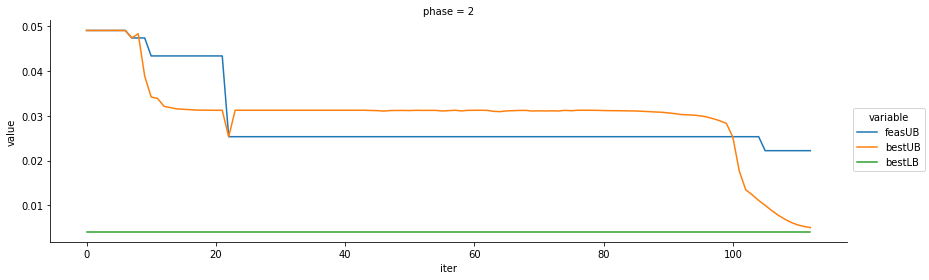

In [20]:
xcol = 'iter'
df_phase2.loc[:,'phase'] = 2
if TWO_PHASE:
    df_phase1.loc[:,'phase'] = 1
    dsplot = pd.concat([df_phase1, df_phase2])
else:
    dsplot = df_phase2
dsplot = dsplot[[xcol,'feasUB','bestUB','bestLB','phase']]
dsplot = dsplot.melt(id_vars=[xcol,'phase'])
dsplot.loc[ dsplot.value>1e1, 'value'] = np.nan
dsplot.loc[ dsplot.value<-1e1, 'value'] = np.nan

g = sns.FacetGrid(dsplot, hue='variable', size=4, aspect=3, row='phase', sharey=False)
g.map(plt.plot, xcol,'value')
g.add_legend()

In [21]:
var_cons_dict = estk.var_cons_dict
powers = estk.powers
digits = estk.digits
radix  = estk.radix

In [22]:
if not sol_master:
    sol_masterk = sub.x_dict
    feasUB = 1e100
    for sub_ind,sub in iteritems(sub_dict):
        yk = np.array([sub.x_dict[v.VarName] for v in sub._ys])        
        obj_dict, feas_dict, sub_stats = master.check_feasible(yk)
        feasUBk = sum(obj_dict.values())
        print("feasUB for %s: %s" % (sub_ind, feasUBk))
        if feasUBk < feasUB:
            feasUB = feasUBk
            sol_masterk = sub.x_dict
else:
    sol_masterk = sol_master

In [23]:
kfit_dict = {}
for group_id, var_dict in iteritems(var_cons_dict):
    var = var_dict[0]
    cons = var_dict[1]
    a0  = var_dict[0][2]
    kfit = 0.
    for l,pwr in enumerate(powers):
        for k,digit in enumerate(digits):            
            yid = 'binary_%s%s%s' % (group_id,k,l)
            y   = sol_masterk[yid]
            kfit += y*a0*radix**pwr*digit
    kfit_dict[group_id] = kfit

kfit_changed = [(k,v, abs(v-a0)/a0) for k,v in iteritems(kfit_dict) if abs(v-a0)/a0>1e-6]
print('Changed keffs: %d/%d' % (len(kfit_changed), len(var_cons_dict)))

Changed keffs: 40/48


In [24]:
#----------------------------------------
# Starting from basal model
perrs = []
errs_fit = []
errs_unfit = []
csrcs = df_conds.cond.unique()
rows = []
for csrc in csrcs:        
    ijofit = load_json_model('/home/laurence/ME/models/e_coli_core_pc.json')
    #--------------------------------------------------
    # Constrain to medium
    df_condi = df_conds[ df_conds.cond==csrc]    
    for i,row in df_condi.iterrows():
        rid = row['rxn']
        rxn = ijofit.reactions.get_by_id(rid)
        rxn.lower_bound = row['lb']
        rxn.upper_bound = row['ub']
    # Get unfit growth rate first
    crowding = ijofit.metabolites.get_by_id('crowding')
    if a0 is not None:
        for rxn in ijofit.metabolites.crowding.reactions:
            rxn._metabolites[crowding] = a0
    ijofit.optimize(solver='gurobi')
    mu_unfiti = ijofit.reactions.BIOMASS_Ecoli_core_w_GAM.x
    
    #--------------------------------------------------
    # Fitted    
    for rid,kfit in iteritems(kfit_dict):
        rxn = ijofit.reactions.get_by_id(rid)
        rxn.add_metabolites({crowding:kfit}, combine=False)
    
    ijofit.optimize(solver='gurobi')
    
    mu_measi = df_meas[ df_meas.substrate==csrc].growth_rate_1_h.iloc[0]
    mu_fiti = ijofit.reactions.BIOMASS_Ecoli_core_w_GAM.x
        
    err0= 100*(mu_unfiti-mu_measi)/mu_measi
    err = 100*(mu_fiti - mu_measi)/mu_measi
    derr= 100*(abs(err)-abs(err0))/abs(err0)
    perrs.append(err)
    errs_unfit.append(mu_unfiti - mu_measi)
    errs_fit.append(mu_fiti - mu_measi)
    print('Cond=%s. mu_meas=%g. mu_sim=%g (unfit=%g, error=%.3g%%). Error=%.3g%% (%.3g%% change)' % (
        csrc, mu_measi, mu_fiti, mu_unfiti, err0, err, derr))
    for i,row in df_condi.iterrows():
        rid = row['rxn']
        rxn = ijofit.reactions.get_by_id(rid)        
        print('\t%s uptake=%g' % (rxn.id, rxn.x))
    
    rows.append({'substrate':csrc, 'mu_fit':mu_fiti, 'mu_unfit':mu_unfiti, 'mu_meas':mu_measi})

perrs = np.array(perrs)
errs_fit = np.array(errs_fit)
errs_unfit = np.array(errs_unfit)
tot_err = sum(abs(errs_fit))
tot_err0 = sum(abs(errs_unfit))
print("Absolute total error: %g"%(tot_err))
print("Total error change: %g%%"%( 100*(tot_err-tot_err0)/tot_err0  ))
print("Absolute percent error: %g%% -- %g%%"%(min(abs(perrs)), max(abs(perrs))))
print("Mean abs percent error = %g%%"%(np.mean(abs(perrs))))
print("Median abs percent error = %g%%"%(np.median(abs(perrs))))

Cond=glucose. mu_meas=0.74. mu_sim=0.709357 (unfit=0.873922, error=18.1%). Error=-4.14% (-77.1% change)
	EX_glc__D_e uptake=-10
	EX_fru_e uptake=0
	EX_succ_e uptake=0
	EX_mal__L_e uptake=0
	EX_ac_e uptake=7.18116
Cond=fructose. mu_meas=0.55. mu_sim=0.741846 (unfit=0.873922, error=58.9%). Error=34.9% (-40.8% change)
	EX_glc__D_e uptake=0
	EX_fru_e uptake=-10
	EX_succ_e uptake=0
	EX_mal__L_e uptake=0
	EX_ac_e uptake=5.76343
Cond=succinate. mu_meas=0.46. mu_sim=0.397563 (unfit=0.397563, error=-13.6%). Error=-13.6% (0% change)
	EX_glc__D_e uptake=0
	EX_fru_e uptake=0
	EX_succ_e uptake=-10
	EX_mal__L_e uptake=0
	EX_ac_e uptake=0
Cond=malate. mu_meas=0.44. mu_sim=0.370741 (unfit=0.370741, error=-15.7%). Error=-15.7% (0% change)
	EX_glc__D_e uptake=0
	EX_fru_e uptake=0
	EX_succ_e uptake=0
	EX_mal__L_e uptake=-10
	EX_ac_e uptake=0
Cond=acetate. mu_meas=0.256. mu_sim=0.389313 (unfit=0.389313, error=52.1%). Error=52.1% (0% change)
	EX_glc__D_e uptake=0
	EX_fru_e uptake=0
	EX_succ_e uptake=0
	EX_

In [25]:
from scipy import stats

df_results = pd.DataFrame(rows)
dsplot = df_results.melt(['substrate','mu_meas'])
dsplot.loc[dsplot.variable=='mu_fit','model'] = 'Fit'
dsplot.loc[dsplot.variable=='mu_unfit','model'] = 'Unfit'
df_perf = dsplot.groupby('variable').apply(lambda x: pd.Series({
    'mdape':100*np.median(abs(x['value']-x['mu_meas'])/abs(x['mu_meas'])),
    'sse':sum( (x['value']-x['mu_meas'])**2 ),
    'rho':stats.spearmanr(x['mu_meas'],x['value'])[0],
    'r':stats.pearsonr(x['mu_meas'],x['value'])[0]
}))

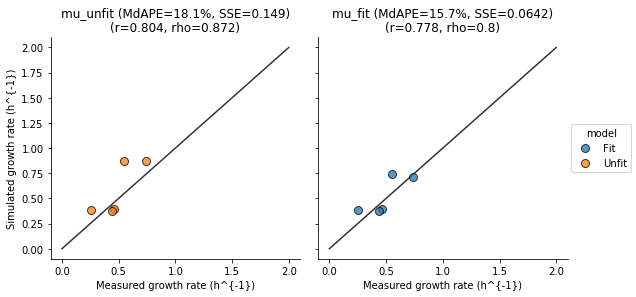

In [26]:
dsplot.variable = dsplot.variable.astype('category')
dsplot.model = dsplot.model.astype('category')
dsplot.variable.cat.reorder_categories(['mu_unfit','mu_fit'], inplace=True)
g = sns.FacetGrid(dsplot, col='variable', hue='model', size=4)
g.map(plt.plot, 'mu_meas','value', linestyle='None', marker='o', markeredgecolor='#000000', lw=0.2, markersize=8, alpha=0.75)
for ax in g.axes.flat:
    ax.plot([0,2],[0,2], zorder=1, color='#333333')
    mdl  = ax.get_title().replace('variable = ','')
    mdape= df_perf.loc[mdl].mdape
    sse  = df_perf.loc[mdl].sse
    r    = df_perf.loc[mdl].r
    rho  = df_perf.loc[mdl].rho    
    ax.set_title('%s (MdAPE=%.3g%%, SSE=%.3g)\n(r=%.3g, rho=%.3g)'%(mdl,mdape, sse, r,rho))
g.set_xlabels('Measured growth rate (h^{-1})')
g.set_ylabels('Simulated growth rate (h^{-1})')
g.add_legend()

## Confirm that all ys the same

In [27]:
y_sames = []
for y in sub._ys:
    sub1 = sub_dict[conds[0]]
    sub2 = sub_dict[conds[1]]
    y1 = sub1.x_dict[y.VarName]
    y2 = sub2.x_dict[y.VarName]
    y_sames.append(abs(y1-y2)<1e-10)
    print('%12.10s%12.10s%12.10s%12.10s'%(y.VarName,y1,y2, abs(y1-y2)<1e-10))    

  binary_G6P         0.0         0.0        True
  binary_G6P         1.0         1.0        True
  binary_G6P         1.0         1.0        True
  binary_AKG         1.0         1.0        True
  binary_AKG         0.0         0.0        True
  binary_AKG         1.0         1.0        True
  binary_ME2         1.0         1.0        True
  binary_ME2         1.0         1.0        True
  binary_ME2         0.0         0.0        True
  binary_PGK         0.0         0.0        True
  binary_PGK         1.0         1.0        True
  binary_PGK         0.0         0.0        True
  binary_GLU         1.0         1.0        True
  binary_GLU         1.0         1.0        True
  binary_GLU         0.0         0.0        True
  binary_ME1         1.0         1.0        True
  binary_ME1         1.0         1.0        True
  binary_ME1         0.0         0.0        True
  binary_GND         1.0         1.0        True
  binary_GND         1.0         1.0        True
  binary_GND        

In [28]:
print('num same = %s/%s'%(sum(y_sames), len(y_sames)))

num same = 144/144
